# Preliminary Analysis of SMA Reactive Taker Strategy

In [7]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

## Data Extraction

Using **SPY** symbol for our analysis and backtesting, in strategy studio we will use IEX data, but since here we just need to test proof of concept, I am using the yfinance library

In [18]:
def fetch_spy_data(ticker="SPY", start_date="2020-01-01", end_date="2023-12-31"):
    spy = yf.Ticker(ticker)
    data = spy.history(start=start_date, end=end_date)
    data.reset_index(inplace=True)  # Reset index to make 'Date' a column
    data = data.rename(columns={"Close": "close", "High": "high", "Low": "low", "Open": "open", "Volume": "volume"})
    data = data[["Date", "open", "high", "low", "close", "volume"]]  # Keep only relevant columns
    return data

# Fetch data
data = fetch_spy_data()
data["Date"] = pd.to_datetime(data["Date"])  # Ensure Date column is datetime

# Parameters
N = 100  # Number of days for SMA

# Calculate SMA
data['SMA'] = data['close'].rolling(window=N).mean()

In [19]:
data.head()

,Date,open,high,low,close,volume,SMA
0,2020-01-02 00:00:00-05:00,300.971435,302.227272,300.031879,302.208649,59151200,NaN
1,2020-01-03 00:00:00-05:00,298.757391,301.064408,298.701578,299.920197,77709700,NaN
2,2020-01-06 00:00:00-05:00,298.134129,301.148141,298.013193,301.064423,55653900,NaN
3,2020-01-07 00:00:00-05:00,300.487738,300.971483,299.762148,300.217987,40496400,NaN
4,2020-01-08 00:00:00-05:00,300.413284,303.055176,300.162128,301.817963,68296000,NaN


In [20]:
data.tail()

,Date,open,high,low,close,volume,SMA
1001,2023-12-22 00:00:00-05:00,469.433280,470.939100,467.293485,469.225250,67126600,436.590247
1002,2023-12-26 00:00:00-05:00,469.641347,472.127878,469.562077,471.206573,55387000,436.889364
1003,2023-12-27 00:00:00-05:00,470.998521,472.207125,470.453671,472.058533,68000300,437.216959
1004,2023-12-28 00:00:00-05:00,472.425074,473.088798,471.810871,472.236847,77158100,437.507993
1005,2023-12-29 00:00:00-05:00,472.038690,472.573654,468.878488,470.869720,122234100,437.804625


## Backtesting and Plotting

In [21]:
# Define signals with momentum confirmation
data['Signal'] = 0  # Default no signal
for i in range(1, len(data)):
    if data['close'].iloc[i] > data['close'].iloc[i-1] and data['close'].iloc[i-1] > data['SMA'].iloc[i-1] and data['close'].iloc[i] > data['SMA'].iloc[i]:
        data.loc[data.index[i], 'Signal'] = 1  # Buy signal
    elif data['close'].iloc[i] < data['close'].iloc[i-1] and data['close'].iloc[i-1] < data['SMA'].iloc[i-1] and data['close'].iloc[i] < data['SMA'].iloc[i]:
        data.loc[data.index[i], 'Signal'] = -1  # Sell signal

In [22]:
# Backtest
initial_capital = 10000
capital = initial_capital
position = 0  # No position initially

data['Portfolio Value'] = float(capital)
for i in range(1, len(data)):
    if data['Signal'].iloc[i] == 1 and position == 0:  # Buy signal
        position = capital / data['close'].iloc[i]
        capital = 0
    elif data['Signal'].iloc[i] == -1 and position > 0:  # Sell signal
        capital = position * data['close'].iloc[i]
        position = 0
    # Update portfolio value
    data.loc[data.index[i], 'Portfolio Value'] = float(capital) + (position * data['close'].iloc[i] if position > 0 else 0)

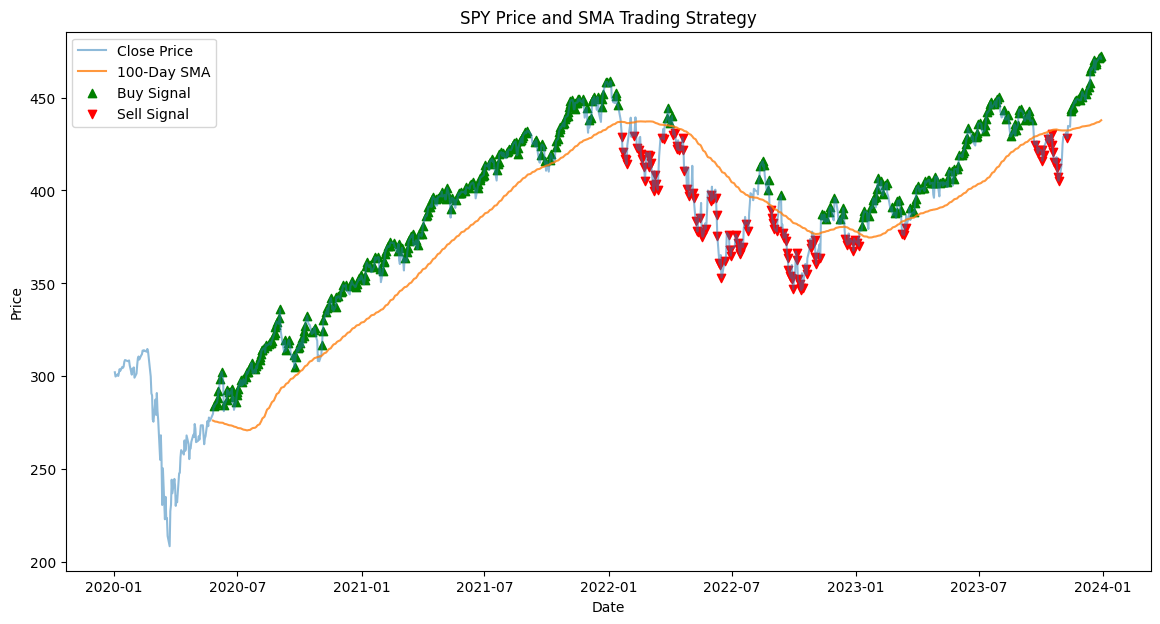

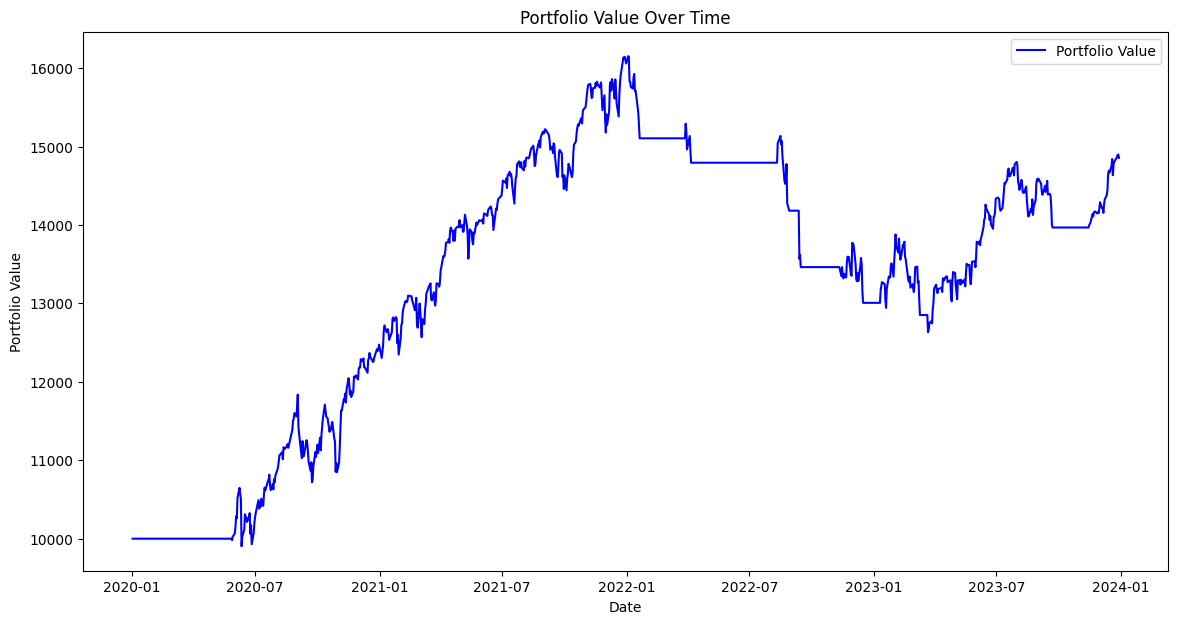

Initial Capital: $10000
Final Portfolio Value: $14854.48


In [23]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['close'], label='Close Price', alpha=0.5)
plt.plot(data['Date'], data['SMA'], label=f'{N}-Day SMA', alpha=0.8)
plt.scatter(data.loc[data['Signal'] == 1, 'Date'], data.loc[data['Signal'] == 1, 'close'], label='Buy Signal', marker='^', color='green')
plt.scatter(data.loc[data['Signal'] == -1, 'Date'], data.loc[data['Signal'] == -1, 'close'], label='Sell Signal', marker='v', color='red')
plt.legend()
plt.title('SPY Price and SMA Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Portfolio Value'], label='Portfolio Value', color='blue')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# Output final portfolio value
final_value = capital + (position * data['close'].iloc[-1] if position > 0 else 0)
print(f"Initial Capital: ${initial_capital}")
print(f"Final Portfolio Value: ${final_value:.2f}")


### Conclusion:

This strategy is **profitable**